# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

2024-03-02 04:26:22.192217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 04:26:22.192417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 04:26:22.365014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 加載音頻訊號

In [2]:
data_path = '/kaggle/input/recoding-data/UAV Recordings 1s/UAV Recordings 1s'

# 音頻訊號進行MFCCs特徵提取

In [3]:
def load_data(data_dir):
    datasets = []
    labels = []
    categories = os.listdir(data_dir)
    for index, folder in enumerate(categories):
        for filename in os.listdir(data_dir+"/"+folder):
            data, sampling_rate = librosa.load(data_dir+"/"+folder+"/"+filename)
            mfccs_features = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=80)
            mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
            datasets.append(np.array(mfccs_scaled_features))
            labels.append(categories[index])
    return np.array(datasets), np.array(labels)

datasets, labels = load_data(data_path)

In [4]:
datasets = datasets.astype('float32')

labelencoder = LabelEncoder()

labelsOneHot = to_categorical(labelencoder.fit_transform(labels))

# 切分成訓練資料、測試資料，8:2的比例

In [5]:
X_train, X_test, y_train, y_test = train_test_split(datasets, labelsOneHot, test_size = 0.2, stratify = labelsOneHot, random_state = 3)

print("----------Train-------------")
print(X_train.shape)

print("----------Test--------------")
print(X_test.shape)

----------Train-------------
(4512, 80)
----------Test--------------
(1128, 80)


# 類別數量

In [6]:
num_classes = len(np.unique(labels))

# 建立GRU模型

In [7]:
# 建立一個Sequential模型
model = Sequential()

# 添加兩個GRU層，設定隱藏層的神經元數量為32
model.add(GRU(128, return_sequences = True, input_shape = (datasets.shape[1], 1)))

model.add(GRU(64, return_sequences = True))

# 使用Dropout防止過度擬合
model.add(Dropout(0.25))

model.add(GRU(32))

# 使用Dropout防止過度擬合
model.add(Dropout(0.25))

# 輸出層，有num_classes個類別，所以輸出層的輸出維度為num_classes
model.add(Dense(num_classes, activation='softmax'))

# 選擇損失函數、優化方法及成效衡量方式
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 80, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 80, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,125 (379.39 KB)

 Trainable params: 97,125 (379.39 KB)

 Non-trainable params: 0 (0.00 B)

# 模型訓練

In [8]:
train_history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 100, epochs = 150, verbose = 2)

Epoch 1/150
37/37 - 18s - 479ms/step - accuracy: 0.3932 - loss: 1.4357 - val_accuracy: 0.4729 - val_loss: 1.2447
Epoch 2/150
37/37 - 11s - 298ms/step - accuracy: 0.4915 - loss: 1.2411 - val_accuracy: 0.4817 - val_loss: 1.1649
Epoch 3/150
37/37 - 12s - 325ms/step - accuracy: 0.5248 - loss: 1.1649 - val_accuracy: 0.5349 - val_loss: 1.1132
Epoch 4/150
37/37 - 20s - 539ms/step - accuracy: 0.5572 - loss: 1.1202 - val_accuracy: 0.5781 - val_loss: 1.0632
Epoch 5/150
37/37 - 11s - 303ms/step - accuracy: 0.5805 - loss: 1.0821 - val_accuracy: 0.5781 - val_loss: 1.0493
Epoch 6/150
37/37 - 21s - 554ms/step - accuracy: 0.6112 - loss: 1.0300 - val_accuracy: 0.6113 - val_loss: 0.9969
Epoch 7/150
37/37 - 11s - 290ms/step - accuracy: 0.6135 - loss: 1.0188 - val_accuracy: 0.6390 - val_loss: 0.9345
Epoch 8/150
37/37 - 10s - 276ms/step - accuracy: 0.6331 - loss: 0.9571 - val_accuracy: 0.6589 - val_loss: 0.9391
Epoch 9/150
37/37 - 11s - 298ms/step - accuracy: 0.6331 - loss: 0.9361 - val_accuracy: 0.6667 - 

# 評估訓練結果

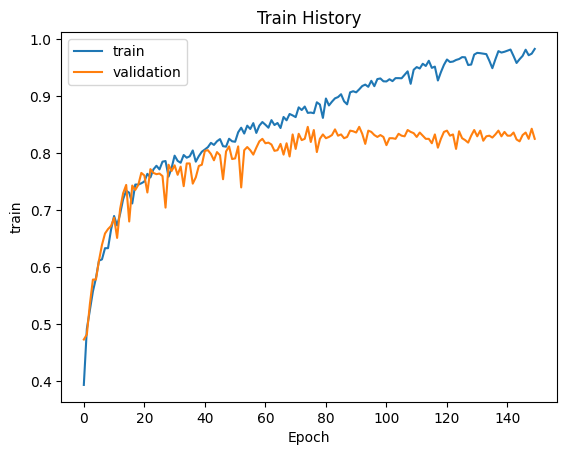

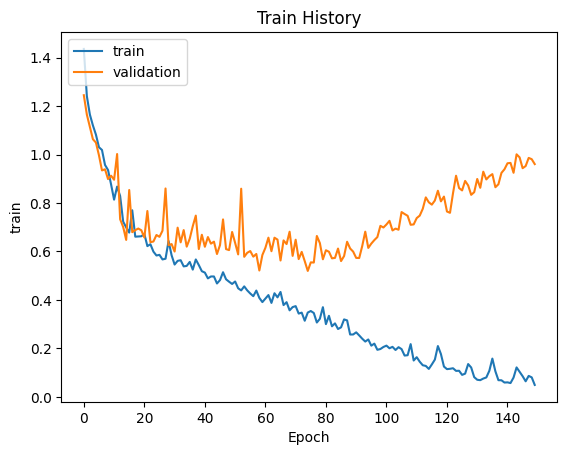

In [9]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])

    plt.plot(train_history.history[validation])

    plt.title('Train History')

    plt.ylabel('train')

    plt.xlabel('Epoch')

    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()
    

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

# 使用未參與訓練的測試資料測試，模型準確率

In [10]:
scores = model.evaluate(X_test,y_test,verbose=0)

print('Accuracy = ', scores[1])

Accuracy =  0.859929084777832


# 評估訓練結果

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


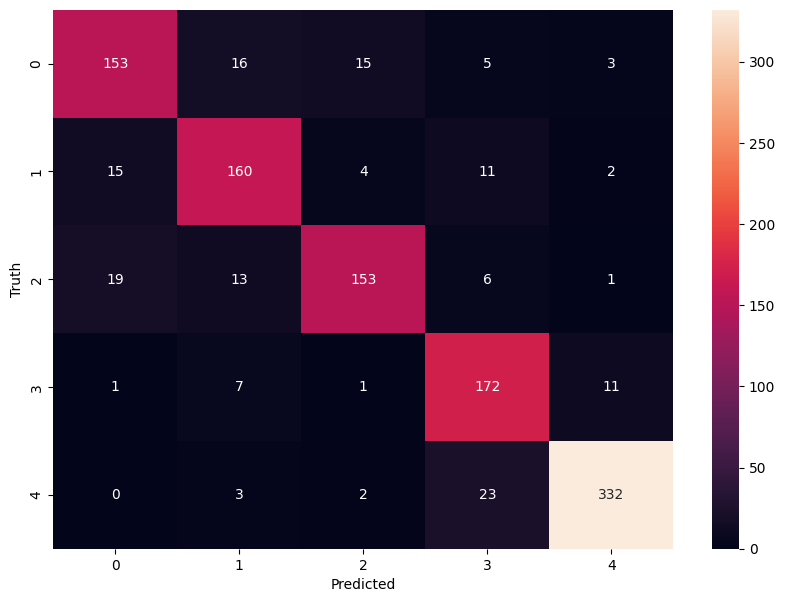

In [11]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()